This is a program which is in testing phase. We will use a linear regression ML model to give an SOC number for the flights.

In [1]:
# Import the querying module
from flight_querying import query_flights
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Set up and retrieve the data from the database.
db_connect = query_flights()

In [2]:
# Make the data dictionary holder
data_dict = {
    "Time Delta": [],
    "SOC Delta": [],
    "Activity": [],
    "Average Power": [],
    "Id": [],
    "Unique Data Identifier": []
}

# Create a increasing int variable to keep track of the Unique Data Identifier
unique_identifier = 0

In [3]:
def data_parser(parsing_dataframe):

    global unique_identifier

    # Get the current exercise
    current_exercise = parsing_dataframe.iloc[0, parsing_dataframe.columns.get_loc('activity')]
    id = parsing_dataframe.iloc[0, parsing_dataframe.columns.get_loc('id')]
    max_soc, min_soc = 0, 101
    power_list = [0]
    min_time, max_time = 100, 0

    # iterate over all the rows
    for index, row in parsing_dataframe.iterrows():

        # Get the data needed from the rows. Append the power
        new_exercise = row["activity"]
        soc = row["soc"]
        power_list.append(row["power"])
        time = row["time"]

        # If the exercise changes or if the rows end.
        if current_exercise != new_exercise or index == len(parsing_dataframe) - 1:

            # Set the values 
            data_dict["Time Delta"].append(round(max_time - min_time, 2))
            data_dict["SOC Delta"].append(max_soc - min_soc)
            data_dict["Activity"].append(current_exercise)
            data_dict["Average Power"].append(round(sum(power_list)/len(power_list), 2))
            data_dict["Id"].append(id)
            data_dict["Unique Data Identifier"].append(unique_identifier)
            unique_identifier = unique_identifier + 1

            # Reset all the values
            max_soc, min_soc = soc, soc
            power_list.clear()
            max_time, min_time = time, time
        
        # SOC
        if soc >= max_soc:
            max_soc = soc
        if soc <= min_soc:
            min_soc = soc

        # TIME
        if time >= max_time:
            max_time = time
        if time <= min_time:
            min_time = time
        
        # Change current exercise
        current_exercise = new_exercise


In [4]:
# Flight IDs to include
flight_ids = [4620, 4929, 4940, 5019, 5021, 5034]

# Fetch data for specified flight IDs
# Remove NA values from each dataframe in the list and put it through the data parser
for ids in flight_ids:
    frame = db_connect.connect_flight_for_ml_data_prescription(ids)
    frame = frame[frame["activity"] != "NA"].reset_index()
    data_parser(frame)

# Concatenate data frames and shuffle the data
# all_data = pd.concat(data_frames, axis=0).sample(frac=1, random_state=42)
all_data = pd.DataFrame(data_dict)

In [5]:
# Split the data into train and test sets
train_data, test_data = train_test_split(all_data, test_size=0.3, random_state=42)

In [6]:
all_data.head()

,Time Delta,SOC Delta,Activity,Average Power,Id,Unique Data Identifier
0,1.0,3,takeoff,53.39,4620,0
1,0.9,4,climb,51.92,4620,1
2,1.3,2,cruise,15.35,4620,2
3,1.2,0,landing,0.08,4620,3
4,0.7,3,takeoff,53.31,4620,4


In [7]:
print(f"Length train_x = {len(train_data)} \n Length train_y = {len(test_data)}")

Length train_x = 67 
 Length train_y = 29


One-Hot-Encoding of the Operations columns

In [8]:
# ONE-HOT ENCODE
# https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
def one_hot(df, col, pre):
  encoded = pd.get_dummies(df[col], prefix=pre)
  for column in encoded:
    encoded = encoded.rename(columns={column: col + "_" + column})
  encoded['Unique Data Identifier'] = df['Unique Data Identifier']
  return encoded

In [9]:
# Encode Train data
train_encoded = one_hot(train_data, "Activity", 'is')
final_train_x = pd.merge(train_data, train_encoded, on=["Unique Data Identifier"])
final_train_y = final_train_x["SOC Delta"].to_numpy()
final_train_x = final_train_x.drop(columns=["SOC Delta", "Id", "Unique Data Identifier", "Activity"])

# Encode Test data
test_encoded = one_hot(test_data, "Activity", 'is')
final_test_x = pd.merge(test_data, test_encoded, on=["Unique Data Identifier"])
final_test_y = final_test_x["SOC Delta"].to_numpy()
final_test_x = final_test_x.drop(columns=["SOC Delta", "Id", "Unique Data Identifier", "Activity"])

In [10]:
final_train_x

,Time Delta,Average Power,Activity_is_climb,Activity_is_cruise,Activity_is_descent,Activity_is_landing,Activity_is_power off stall,Activity_is_power on stall,Activity_is_slow flight,Activity_is_steep turns,Activity_is_takeoff
0,0.7,29.97,False,False,False,False,False,False,False,True,False
1,2.3,43.48,True,False,False,False,False,False,False,False,False
2,1.1,44.94,True,False,False,False,False,False,False,False,False
3,0.8,0.02,False,False,True,False,False,False,False,False,False
4,1.0,44.63,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
62,0.7,44.04,True,False,False,False,False,False,False,False,False
63,3.4,17.77,False,False,False,False,False,False,True,False,False
64,1.5,20.41,False,True,False,False,False,False,False,False,False
65,0.7,53.09,False,False,False,False,False,False,False,False,True


In [11]:
print(f"Length test_encoded = {len(test_encoded)} \n Length train_encoded = {len(train_encoded)}")

Length test_encoded = 29 
 Length train_encoded = 67


In [12]:
print(f"Length train_x = {len(final_train_x)} \n Length train_y = {len(final_train_y)}")

Length train_x = 67 
 Length train_y = 67


In [13]:
print(f"Length test_x = {len(final_test_x)} \n Length test_y = {len(final_test_y)}")

Length test_x = 29 
 Length test_y = 29


Machine Learning Model Implementation

In [14]:
# import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set model
regression_model = LinearRegression()

# Fit model
regression_model.fit(final_train_x, final_train_y)

LinearRegression()

In [15]:
# Make predictions using the testing set
y_pred = regression_model.predict(final_test_x)

In [16]:
# print model score
print(regression_model.score(final_test_x, final_test_y))

0.7781807849422742


In [17]:
from sklearn.metrics import mean_squared_error, r2_score

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(final_test_y, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(final_test_y, y_pred))

Mean squared error: 2.94
Coefficient of determination: 0.78


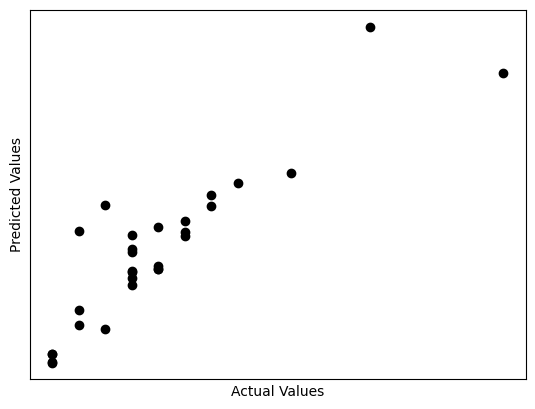

In [18]:
import matplotlib.pyplot as plt

# Plot outputs
plt.scatter(final_test_y, y_pred, color="black")

plt.xticks(())
plt.yticks(())

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

plt.show()

In [19]:
coeff = pd.DataFrame(list(zip(regression_model.feature_names_in_, regression_model.coef_)), columns = ['Feature', 'Weight'])
coeff.sort_values('Weight')

,Feature,Weight
5,Activity_is_landing,-1.223592
10,Activity_is_takeoff,-0.846188
7,Activity_is_power on stall,-0.456523
4,Activity_is_descent,-0.371398
8,Activity_is_slow flight,-0.146813
1,Average Power,0.068369
6,Activity_is_power off stall,0.382344
3,Activity_is_cruise,0.722726
9,Activity_is_steep turns,0.793291
2,Activity_is_climb,1.146153


In [20]:
# Set index and initial exercise
# start_index = 0
# current_exercise = df.iloc[0, df.columns.get_loc('activity')]

# # iterate over all the rows
# for index, row in df.iterrows():

#     # Initalize new exercise
#     new_exercise = row["activity"]

#     # See if the exercise changes
#     if current_exercise != new_exercise or index == len(df):

#         # Get SOC for the exercise and store the change from max to min.
#         soc_range = df.iloc[start_index:index-1, df.columns.get_loc('soc')]
#         soc_max, soc_min = np.max(soc_range), np.min(soc_range)
#         data_dict["SOC Delta"].append(soc_max - soc_min)

#         print(f"SOC Max: {soc_max}, SOC Min: {soc_min}")

#         # Get Time for the exercise and store the change from max to min.
#         time_range = df.iloc[start_index:index-1, df.columns.get_loc('time')]
#         time_start, time_end = np.min(time_range), np.max(time_range)
#         data_dict["Time Delta"].append(round(time_end - time_start, 2))

#         # Get the Average Power
#         power_average = np.mean(df.iloc[start_index:index-1, df.columns.get_loc('power')])
#         data_dict["Average Power"].append(round(power_average, 2))

#         # Set the id and activity
#         data_dict["Id"].append(row["id"])
#         data_dict["Activity"].append(current_exercise)

#         # Reset the index and exercise to the one 
#         start_index = index
#         current_exercise = new_exercise
    
#     if index == len(df):
#         break